In [1]:
# Task 3

In [2]:
# Deep Learning Model

In [3]:
#Download of kaggle.json from google drive

In [4]:
! gdown --id 18_e1gBcQxf_S-FnhxIc3b-D8mVNFZ9WV

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18_e1gBcQxf_S-FnhxIc3b-D8mVNFZ9WV
To: /content/kaggle.json
100% 65.0/65.0 [00:00<00:00, 203kB/s]


In [5]:
# If I need

In [22]:
pip install mxnet==1.5.1


In [ ]:
# downlaod  CSV files and test and train pictures

In [8]:
pip install kaggle

In [11]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set your Kaggle API credentials
os.environ["KAGGLE_USERNAME"] = "maryamsaa"
os.environ["KAGGLE_KEY"] = "b73d47e88e6150c7dbb3ae61c96b1024"

# Specify the competition name
competition_name = "dogs-vs-cats-redux-kernels-edition"

# Set the working directory to where you want to download the files
#os.chdir("my-work")

# Create a Kaggle API object
api = KaggleApi()
api.authenticate()



In [12]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset


 99% 1.18G/1.19G [00:11<00:00, 148MB/s]
100% 1.19G/1.19G [00:11<00:00, 114MB/s]


In [13]:
import zipfile

with zipfile.ZipFile('coronahack-chest-xraydataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [14]:
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
# Train and Test df and Label

In [15]:
# Reading through the metadata
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
df = pd.read_csv('Chest_xray_Corona_Metadata.csv')

replace_dict = {'Pnemonia': 1, 'Normal': 0}
df['Label'] = df['Label'].replace(replace_dict)

train_df = df[df.Dataset_type == 'TRAIN']
test_df = df[df.Dataset_type == 'TEST']

# Defining the path to Train and Test directories
training_data_path = '/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
testing_data_path = '/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'



In [ ]:
# Function to read and preprocess images
def read_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.transpose((2, 0, 1))  # Transpose to (channels, height, width)
    img = img / 255.0
    return nd.array(img)


In [ ]:
# Loading and preprocessing the data
train_data = [(read_image(os.path.join(training_data_path, img)), label) for img, label in zip(train_df['X_ray_image_name'], train_df['Label'])]
test_data = [(read_image(os.path.join(testing_data_path, img)), label) for img, label in zip(test_df['X_ray_image_name'], test_df['Label'])]

# Splitting the data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Creating data loaders
batch_size = 32
train_loader = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = gluon.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
# Get the shape of the first batch from the training loader
for data, label in train_loader:
    input_shape = data.shape[1:]
    break

print("Training Data Shape:", input_shape)

# Get the shape of the first batch from the validation loader
for data, label in val_loader:
    input_shape = data.shape[1:]
    break

print("Validation Data Shape:", input_shape)

# Get the shape of the first batch from the test loader
for data, label in test_loader:
    input_shape = data.shape[1:]
    break

print("Test Data Shape:", input_shape)


Training Data Shape: (3, 224, 224)
Validation Data Shape: (3, 224, 224)
Test Data Shape: (3, 224, 224)


In [ ]:
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, loss, Trainer
# Modify the CNN model
class SimplestCNN(nn.Block):
    def __init__(self, **kwargs):
        super(SimplestCNN, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(32, kernel_size=3, activation='relu')
        self.pool1 = nn.MaxPool2D(pool_size=2, strides=2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Dense(64, activation='relu')
        self.dense2 = nn.Dense(1)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x


# Initialize the simplest model
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
net = SimplestCNN()
net.initialize(init.Xavier(), ctx=ctx)
criterion = loss.SigmoidBinaryCrossEntropyLoss()
optimizer = Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})


dummy_data = mx.nd.random.uniform(shape=(batch_size, 3, 224, 224), ctx=ctx)
net.summary(dummy_data)

example_data = mx.nd.random.uniform(shape=(batch_size, 3, 224, 224), ctx=ctx)
output = net(example_data)
print("Model Output Shape:", output.shape[1:])


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (32, 3, 224, 224)               0
        Activation-1                     <Symbol conv5_relu_fwd>               0
        Activation-2                          (32, 32, 222, 222)               0
            Conv2D-3                          (32, 32, 222, 222)             896
         MaxPool2D-4                          (32, 32, 111, 111)               0
           Flatten-5                                (32, 394272)               0
        Activation-6                    <Symbol dense6_relu_fwd>               0
        Activation-7                                    (32, 64)               0
             Dense-8                                    (32, 64)        25233472
             Dense-9                                     (32, 1)              65
      SimplestCNN-10        

In [ ]:
#Training loop
import mxnet.gluon.loss as gloss
from mxnet.metric import Accuracy
loss_fn = gloss.SigmoidBinaryCrossEntropyLoss()
metric = Accuracy()
num_epochs = 10
for epoch in range(num_epochs):
    # Training loop
    for data, label in train_loader:
        # Move data and label to the GPU if available
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx).astype('float32')  # Convert label to float32

        # Forward pass
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step(batch_size)

        # Update training metric
        binary_output = output > 0.5  # Apply threshold for binary classification
        metric.update([label], [binary_output])

    # Get training metric result
    name, acc = metric.get()
    print(f"Epoch {epoch + 1}, Training Binary Accuracy: {acc}")

    # Reset metrics for validation
    metric.reset()

    # Validation loop
    for data, label in val_loader:
        # Move data and label to the GPU if available
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx).astype('float32')  # Convert label to float32

        # Forward pass
        output = net(data)

        # Update validation metric
        binary_output = output > 0.5  # Apply threshold for binary classification
        metric.update([label], [binary_output])

    # Get validation metric result
    name, acc = metric.get()
    print(f"Epoch {epoch + 1}, Validation Binary Accuracy: {acc}")
    # Reset metrics for the next epoch
    metric.reset()


Epoch 1, Training Binary Accuracy: 0.25047303689687794
Epoch 1, Validation Binary Accuracy: 0.2674858223062382
Epoch 2, Training Binary Accuracy: 0.25047303689687794
Epoch 2, Validation Binary Accuracy: 0.2674858223062382
Epoch 3, Training Binary Accuracy: 0.25047303689687794
Epoch 3, Validation Binary Accuracy: 0.2674858223062382
Epoch 4, Training Binary Accuracy: 0.25047303689687794
Epoch 4, Validation Binary Accuracy: 0.2674858223062382
Epoch 5, Training Binary Accuracy: 0.25047303689687794
Epoch 5, Validation Binary Accuracy: 0.2674858223062382
Epoch 6, Training Binary Accuracy: 0.25047303689687794
Epoch 6, Validation Binary Accuracy: 0.2674858223062382
Epoch 7, Training Binary Accuracy: 0.25047303689687794
Epoch 7, Validation Binary Accuracy: 0.2674858223062382
Epoch 8, Training Binary Accuracy: 0.25047303689687794
Epoch 8, Validation Binary Accuracy: 0.2674858223062382
Epoch 9, Training Binary Accuracy: 0.25047303689687794
Epoch 9, Validation Binary Accuracy: 0.2674858223062382
E

In [ ]:
# Machine Learning  Model

Validation Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       283
           1       0.96      0.99      0.97       775

    accuracy                           0.96      1058
   macro avg       0.96      0.93      0.94      1058
weighted avg       0.96      0.96      0.96      1058



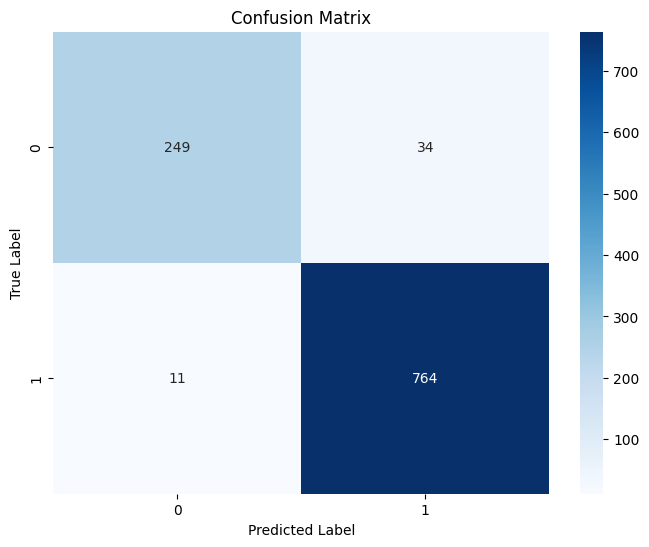

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_images(file_paths):
    images = []
    for path in file_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))  # Resize images to a common size
        images.append(img.flatten())  # Flatten the image into a 1D array
    return np.array(images)

# Load training data
train_images = load_images([os.path.join(training_data_path, filename) for filename in train_df['X_ray_image_name']])
X_train, X_val, y_train, y_val = train_test_split(train_images, train_df['Label'], test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train SVM
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = svm.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {accuracy:.2f}')

print(classification_report(y_val, val_predictions))

# Generate confusion matrix
cm = confusion_matrix(y_val, val_predictions)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
